# 프로젝트 : 폐렴 진단기 성능 개선
#### background
- 실습 시 만든 모델은 test 데이터로 예측 시 약 70~80% 정도의 정확도를 보여줬다.
- 일반 의사는 약 90%대라고 하니 이 기준에 맞춰 개선해보도록 한다.

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### # 실험에 쓸 변수들 생성

> 실습과 달리 EPOCHS만 25 -> 30으로 증가시켜 봄

In [2]:
# 데이터 로드 효율성 증가
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-ray 이미지 사이즈
IMAGE_SIZE = (180, 180)

# 데이터 경로
ROOT_PATH = os.path.join(os.getenv("HOME"), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 실험용 변수
BATCH_SIZE = 16
EPOCHS = 30

print(ROOT_PATH)
print(TRAIN_PATH)

/aiffel/aiffel
/aiffel/aiffel/chest_xray/data/train/*/*


## Step 2. 데이터 준비하기

#### # 파일 경로 전처리

In [3]:
# 파일 경로들 리스트로 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# validation 데이터가 너무 적으니
# train과 합쳐서 다시 무작위로 8:2 비율로 가져오기
temp_filenames = tf.io.gfile.glob(TRAIN_PATH)
temp_filenames.extend(tf.io.gfile.glob(VAL_PATH))

np.random.seed(2022)
np.random.shuffle(temp_filenames)
new_train_num = math.floor(len(temp_filenames)*0.8)

print(len(temp_filenames))
print(new_train_num)

train_filenames = temp_filenames[:new_train_num]
val_filenames = temp_filenames[new_train_num:]
print(len(temp_filenames)-new_train_num == len(val_filenames))
print('==================================================')
print('현재 정리된 데이터 개수')
print(f'train_filenames : {len(train_filenames)}')
print(f'test_filenames : {len(test_filenames)}')
print(f'val_filenames : {len(val_filenames)}')

5232
4185
True
현재 정리된 데이터 개수
train_filenames : 4185
test_filenames : 624
val_filenames : 1047


> #### 손코딩으로 직접 치다가 아래와 같이 쳐서 오류가 났었고, 이로 인해 `list.extend(string)` 이렇게 스트링을 넣으면 어떻게 되는지 알 수 있었다.
> - 정답 : `temp_filenames.extend(tf.io.gfile.glob(VAL_PATH))`
> - 실수 : `temp_filenames.extend(VAL_PATH)`
>    - 근데 문제는 이렇게 해도 오류가 안 나서 모른다는 것이다.
>    - 그런데 숫자가 다르길래 이상해서 보다가 알게 되었다.
>    - 실수처럼 넣었을 경우엔 `'/aiffel/aiffel/chest_xray/data/val/*/*'` 이 string의 철자 하나씩 extend되어 들어간다.

In [5]:
# 파일 경로들 TensorSliceDataset으로 만들어주기
train_tsd = tf.data.Dataset.from_tensor_slices(train_filenames)
test_tsd = tf.data.Dataset.from_tensor_slices(test_filenames)
val_tsd = tf.data.Dataset.from_tensor_slices(val_filenames)

# 전체 데이터 개수 사용의 효율성을 위한 변수 할당
TRAIN_IMG_COUNT = len(train_tsd)
VAL_IMG_COUNT = len(val_tsd)

print('객체 종류 및 개수 확인')
print('==============================================')
print(type(train_tsd), len(train_tsd))
print(type(test_tsd), len(test_tsd))
print(type(val_tsd), len(val_tsd))

객체 종류 및 개수 확인
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 4185
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 624
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 1047


In [6]:
# tf.data.experimental.cardinality를 통한 갯수 확인
print(f'train_tsd : {tf.data.experimental.cardinality(train_tsd)}개')
print(f'test_tsd : {tf.data.experimental.cardinality(test_tsd)}개')
print(f'val_tsd : {tf.data.experimental.cardinality(val_tsd)}개')

train_tsd : 4185개
test_tsd : 624개
val_tsd : 1047개


#### # 본격적인 이미지 파일 불러오기

> #### 직관적으로 다가오는 이미지 파일 불러오기 방법을 시도해봤다(`cv2.imread(path)` 비슷하게)  
> 하지만 `tf.io.read_file(train_filenames)`로서 리스트 형식을 넣는 것은 오류가 난다.
> - `>>>InvalidArgumentError: Input filename tensor must be scalar, but had shape: [4185] [Op:ReadFile]`  
>
> 혹은 for loop으로 `tf.io.read_file(each_path)`를 해보면 오류는 안 나는데,
> - `>>> tf.Tensor(b'\xff\xd8\xff...`하는 게 반환된다..
> - 왜 그럴까?
> - 현재 지식으로 이유가 정확히 파악 안되지만, tensorflow는 뭔가 tensorflow의 자료형으로 넣어야 하는 것 같다.
> - 1) `tf.data.Dataset.from_tensor_slices`를 통해 `<TensorSliceDataset shapes: (), types: tf.string>` 객체를 만들고
> - 2) `객체명.map()`을 통해 각각의 파일명에 함수를 적용해야 하는데,
> - 3) 이 때 `tf.io.read_file(file_path)`를 하면 이미지 파일이 tensor로 반환된다.

In [7]:
# 참고로 현재 라벨이 없는데,
# 라벨은 file path에서 확인 가능하고,
# 그것을 통해 라벨을 추가하자
for path in train_tsd.take(1):
    print(path)
    print(tf.strings.split(path, os.path.sep))
    print('=======================================')
    print(tf.strings.split(path, os.path.sep)[-2])

tf.Tensor(b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person124_virus_245.jpeg', shape=(), dtype=string)
tf.Tensor(
[b'' b'aiffel' b'aiffel' b'chest_xray' b'data' b'train' b'PNEUMONIA'
 b'person124_virus_245.jpeg'], shape=(8,), dtype=string)
tf.Tensor(b'PNEUMONIA', shape=(), dtype=string)


In [8]:
# 필요한 함수 정의

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [9]:
# 이미지 데이터 불러오기
train_ds = train_tsd.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_tsd.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_tsd.map(process_path, num_parallel_calls=AUTOTUNE)

# test_ds는 또 다른 전처리가 필요없고, 추후 batch로 들어갈 것이니 batch화 해준다
test_ds = test_ds.batch(BATCH_SIZE)

In [10]:
print(type(train_ds.cardinality()), train_ds.cardinality().numpy())
print(type(test_ds.cardinality()), test_ds.cardinality().numpy())
print(type(val_ds.cardinality()), val_ds.cardinality().numpy())

<class 'tensorflow.python.framework.ops.EagerTensor'> 4185
<class 'tensorflow.python.framework.ops.EagerTensor'> 39
<class 'tensorflow.python.framework.ops.EagerTensor'> 1047


In [11]:
# 잘 만들어졌는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


#### # data augmentation한 데이터 추가하기

> - background에도 기재했듯이 실습 시 모델의 정확도는 80%가 잘 넘지 못한다.
> - 그래서 data augmentation 할 것을 제안하면서 `좌우 flip`한 데이터의 증가를 구체적으로 제안했는데,
> - 사실 세균성 폐렴의 경우 오른쪽 상부 엽에 나타난다고 하길래, 이 경우 `좌우 flip`의 효과가 있을지 의문이었다.
> - 하지만 조원들의 의견 중 `단순히 폐렴 or 정상의 분류로서 음영의 차이가 판가름하는 것이니 나쁘지 않을 것 같다`는 의견이 있었고,
> - 또 링크(https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/discussion/66130)의 의견상으로도 horizontal flip은 효율 증가가 있다는 의견이 있었다.
> - 그래서 `좌우 flip`한 데이터를 증가시키기로 했다.

> #### 이에 따라 data augmentation은 랜덤하게 좌우 flip한 것을 기본으로 세팅하고, 추후 ablation study는 모델 설계 부분에서 진행할 예정이다.
> - 만약 augmentation 효과가 더 낮다고 판단될 때(test 시 계속 70%대 정확도일 경우)는 다시 augmentation 적용 여부를 짚고 넘어가겠다.

In [12]:
# 좌우 랜덤하게 반전한 함수를 추가하고,
# 해당 함수를 적용해서 데이터셋에 반전된 종류도 넣어주기
# 실제적으로 데이터 숫자가 늘어나는 augmentation은 아니지만,
# repeat()을 통해 숫자가 많아지는 셈 된다고 이해했습니다.
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [13]:
# train, val 전처리
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [14]:
print(train_ds)
print(val_ds)
print(test_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


## Step 3. 데이터 시각화

> - tf.datset 자료형은 구조가 `훈련데이터+라벨데이터`인 상태여서 조금 독특하다.
> - 배치에 있는 데이터를 꺼내서 보고 싶으면 두 종류의 데이터형을 반환받고, 그것을 통해 for loop을 돌리든지 하면 되는 것 같다.

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

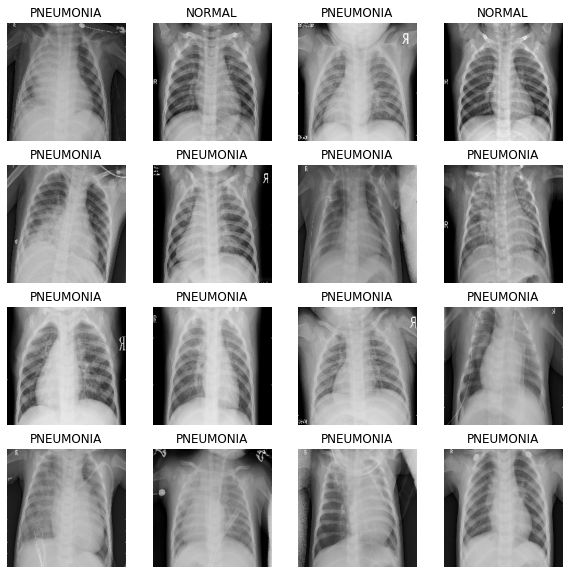

In [16]:
temp_image_batch, temp_label_batch = next(iter(train_ds))
show_batch(temp_image_batch, temp_label_batch)

> `next(iter())`가 뭘하는지 참고용
> ```python
> mylist = iter(["apple", "banana", "cherry"])
> x = next(mylist)
> print(x)
> x = next(mylist)
> print(x)
> x = next(mylist)
> print(x)
> ```

#### 실제로 data가 좌우 반전이 됐는지 확인해보기
> 이를 위해 original `dataset`에서 shuffle하지 않고 동일한 순서로 있는 데이터셋 2개에 각각 반전을 적용, 적용하지 않은 채로 확인해봐야겠다.

In [17]:
fake_train_ds = train_tsd.map(process_path, num_parallel_calls=AUTOTUNE)

In [18]:
# 좌우대칭 없는 것
fake_train_ds_no = fake_train_ds.batch(BATCH_SIZE)
fake_train_ds_no = fake_train_ds_no.prefetch(buffer_size=AUTOTUNE)

# 좌우대칭 있는 것
fake_train_ds_yes = fake_train_ds.map(augment, num_parallel_calls=2)
fake_train_ds_yes = fake_train_ds_yes.batch(BATCH_SIZE)
fake_train_ds_yes = fake_train_ds_yes.prefetch(buffer_size=AUTOTUNE)

# 배치 하나씩 꺼내기
no_img, no_label = next(iter(fake_train_ds_no))
yes_img, yes_label = next(iter(fake_train_ds_yes))

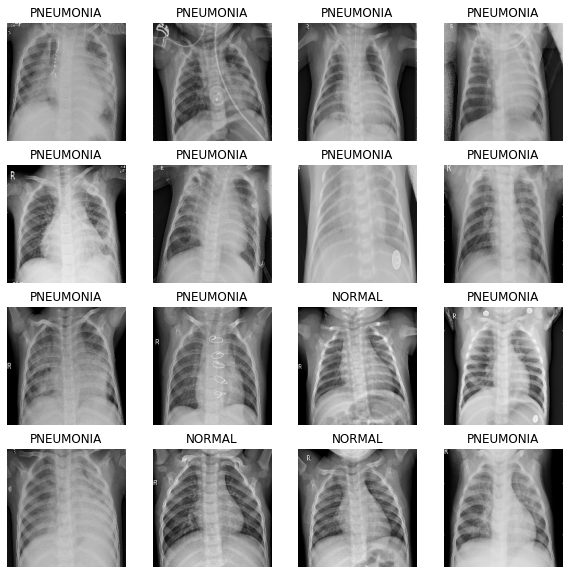

In [19]:
show_batch(no_img, no_label)

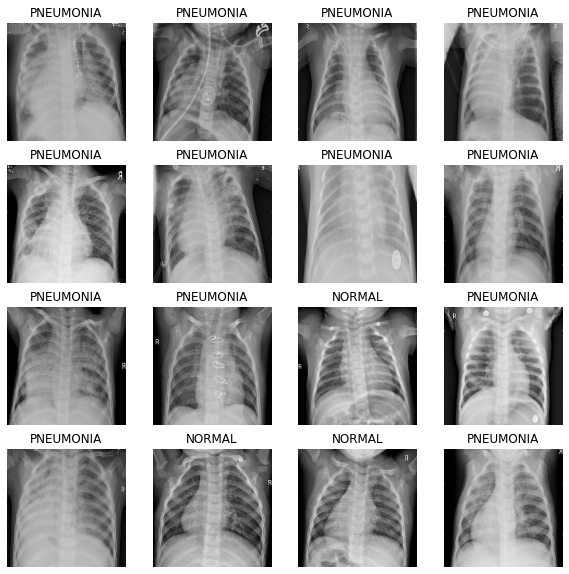

In [20]:
show_batch(yes_img, yes_label)

> 동일한 사진들의 반전/미반전 적용 효과를 놓고 봤을 때 적용된 것으로 확인했다.

## Step 4. CNN 모델링

#### 모델 설계용 함수 만들기
> 추후 정확도가 낮을 경우, 실험을 위해 여러 형태 버전으로 함수를 준비할 예정이다.

In [21]:
# BatchNormalization이 담긴 conv block 만드는 함수
def conv_block_regs(filters, kernel_size=3):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.SeparableConv2D(filters, kernel_size, activation='relu', padding='same'))
    block.add(tf.keras.layers.SeparableConv2D(filters, kernel_size, activation='relu', padding='same'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())
    return block

In [22]:
# 위와 반대의 conv block 함수
def conv_block_ordinary(filters, kernel_size=3):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.SeparableConv2D(filters, kernel_size, activation='relu', padding='same'))
    block.add(tf.keras.layers.SeparableConv2D(filters, kernel_size, activation='relu', padding='same'))
    block.add(tf.keras.layers.MaxPool2D())
    return block

In [23]:
# 규제가 두 종류 있는 dense block 함수
def dense_block_regs(units, dropout_rate=0.5):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Dense(units, activation='relu'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.Dropout(dropout_rate))
    return block

In [24]:
# 규제가 없는 dense block 함수
def dense_block_ordinary(units):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Dense(units, activation='relu'))
    return block

#### # 1차 모델 설계
> - 실습시와 동일하게 진행해볼 예정

In [25]:
def build_model_1st():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_regs(32),
        conv_block_regs(64),
        
        conv_block_regs(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block_regs(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_regs(512, 0.7),
        dense_block_regs(128, 0.5),
        dense_block_regs(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

> - 데이터 내에서 클래스별 imbalance는 훈련에 지장을 준다.
> - 특히 더 적은 수를 가진 클래스가 더 중요하게 예측되어야 하는 클래스라면 해당 클래스가 더 잘 훈련되게끔 도와줘야 한다.

In [26]:
# 데이터 imbalance 확인
positive_count = 0
label_group = []
for path in train_tsd:
    strings = tf.strings.split(path, os.path.sep)
    label = strings[-2] == 'PNEUMONIA'
    label_group.append(label)
    if label == True:
        positive_count += 1

print(f'전체 훈련 데이터 개수 : {len(train_tsd)}')
print(f'양성 훈련 데이터 개수 : {positive_count}')
print(f'양성 훈련 데이터 비율 : {positive_count/len(label_group)*100:.2f}')
print('==============================================')
print(f'라벨 처음 5개만 보기 : {label_group[:5]}')

전체 훈련 데이터 개수 : 4185
양성 훈련 데이터 개수 : 3109
양성 훈련 데이터 비율 : 74.29
라벨 처음 5개만 보기 : [<tf.Tensor: shape=(), dtype=bool, numpy=True>, <tf.Tensor: shape=(), dtype=bool, numpy=True>, <tf.Tensor: shape=(), dtype=bool, numpy=True>, <tf.Tensor: shape=(), dtype=bool, numpy=True>, <tf.Tensor: shape=(), dtype=bool, numpy=True>]


In [27]:
# 다른 방법으로 2차 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1076
Pneumonia images count in training set: 3109


> 실습 시와 양성 훈련 데이터 갯수가 다르길래 생각해봤더니 validation 데이터를 추가하고 다른 `random.seed()`로 shuffle 및 추출했기 때문인 것 같다.

> 그리고 여기서는 중요한 양성 데이터가 오히려 3/4 정도로 많다.  
> 그래도 전반적인 정확도 향상을 위해 일단 `weight balancing`을 진행해보겠다.

In [28]:
# 적용할 가중치 계산
# 전체 데이터 개수에 대한 해당 클래스의 비율의 역수를 계산하고 2로 나눈다
weight_for_neg = (new_train_num / COUNT_NORMAL) / 2.0
weight_for_pos = (new_train_num / COUNT_PNEUMONIA) / 2.0

balancing_weights = {0:weight_for_neg, 1:weight_for_pos}
print(weight_for_neg)
print(weight_for_pos)

1.9447026022304832
0.6730459954969443


## Step 6. 모델 훈련
### 후보 1) 실습 때와 동일하게 BatchNormalization + Dropout 둘 다 적용

In [29]:
with tf.device('/GPU:0'):
    model = build_model_1st()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [31]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights
    )

Epoch 1/30
261/261 [==============================] - 53s 139ms/step - loss: 0.5737 - accuracy: 0.7178 - precision: 0.9056 - recall: 0.6873 - val_loss: 0.5982 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 34s 128ms/step - loss: 0.2617 - accuracy: 0.8945 - precision: 0.9752 - recall: 0.8810 - val_loss: 1.0580 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 33s 128ms/step - loss: 0.2221 - accuracy: 0.9132 - precision: 0.9745 - recall: 0.9069 - val_loss: 0.7007 - val_accuracy: 0.7471 - val_precision: 0.7447 - val_recall: 1.0000
Epoch 4/30
261/261 [==============================] - 33s 128ms/step - loss: 0.1909 - accuracy: 0.9225 - precision: 0.9756 - recall: 0.9179 - val_loss: 0.5541 - val_accuracy: 0.8038 - val_precision: 1.0000 - val_recall: 0.7351
Epoch 5/30
261/261 [==============================] - 33s 128ms/step - loss: 0.1898 - accura

## Step 7. 결과 확인과 시각화

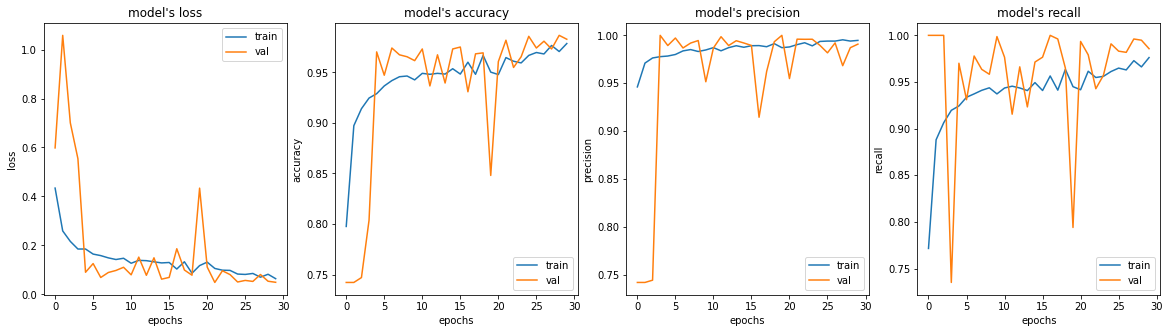

In [32]:
metrics_list = ['loss', 'accuracy', 'precision', 'recall']
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for idx, met in enumerate(metrics_list):
    ax[idx].plot(history.history[met], label='train')
    ax[idx].plot(history.history['val_' + met], label='val')
    ax[idx].set_title(f"model's {met}")
    ax[idx].set_xlabel('epochs')
    ax[idx].set_ylabel(met)
    ax[idx].legend()

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [34]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 69ms/step - loss: 1.0706 - accuracy: 0.7869 - precision: 0.7466 - recall: 0.9974
Loss: 1.070582628250122,
Accuracy: 0.7868589758872986,
Precision: 0.7466410994529724,
Recall: 0.9974358677864075


In [35]:
# 결과 비교를 위한 저장
import pandas as pd

result_1 = pd.Series([loss, accuracy, precision, recall], index=['loss', 'accuracy', 'precision', 'recall'], name='1st')
result_1

loss         1.070583
accuracy     0.786859
precision    0.746641
recall       0.997436
Name: 1st, dtype: float64

> #### feedback
> - 이번 모델은 실습 때 그대로를 사용했고, `epoch`만 25 -> 30으로 높였다.
>   - 안정적으로 수렴할 기회를 좀 늘려주고자(?) epoch를 늘려봤다.
> - 전반적인 test 데이터셋에 대한 예측도를 알려주는 `Accuracy`가 여전히 78%~ 83% 정도 나오는 것 같다.
> - 반면에 진짜 양성 중 양성 판별을 받은 비율을 나타내는 중요한 지표인 `Recall`는 93% ~ 97% 정도로 높고 `Precision`은 상대적으로 낮은 걸 보니, 음성에 대한 판별 중 양성으로 된 False Positive가 많은 것 같다.
> - 그리고 validation 데이터셋의 지표들이 어떤 경우에는 안정적으로 수렴하고, 다른 때에는 그렇지 않다...
> - 좀 더 개선된 모델을 만들어보고자 여러 실험을 해보도록 하겠다.

### 실험) 규제는 어느 정도가 좋을까?
#### 목록
1. BatchNormalization + Dropout 둘 다 실행
2. 규제 X  
3. BatchNormalization만  
4. Dropout만(0.5로 세팅)

### 후보 2) 규제가 없는 모델로 진행해보자
- BatchNormalization + Dropout 둘 다 없앤 모델로 시도
- 그냥 해보자.
- 뭐가 나오는지 궁금하다.

In [36]:
def build_model_2nd():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_ordinary(32),
        conv_block_ordinary(64),
        
        conv_block_ordinary(128),
#        tf.keras.layers.Dropout(0.2),
        
        conv_block_ordinary(256),
#        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_ordinary(512),
        dense_block_ordinary(128),
        dense_block_ordinary(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [37]:
with tf.device('/GPU:0'):
    model = build_model_2nd()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [38]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2032      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7136      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)       26560     
_________________________________________________________________
sequential_11 (Sequential)   (None, 5, 5, 256)       

In [39]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights
    )

Epoch 1/30
261/261 [==============================] - 39s 126ms/step - loss: 0.6929 - accuracy: 0.4436 - precision: 0.7204 - recall: 0.3998 - val_loss: 0.6958 - val_accuracy: 0.2606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
261/261 [==============================] - 32s 124ms/step - loss: 0.6935 - accuracy: 0.2816 - precision: 0.3257 - recall: 0.0543 - val_loss: 0.6937 - val_accuracy: 0.2596 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
261/261 [==============================] - 32s 124ms/step - loss: 0.6924 - accuracy: 0.2566 - precision: 0.0266 - recall: 7.5365e-04 - val_loss: 0.6931 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 4/30
261/261 [==============================] - 32s 123ms/step - loss: 0.6947 - accuracy: 0.4569 - precision: 0.7185 - recall: 0.4373 - val_loss: 0.6932 - val_accuracy: 0.2606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
261/261 [==============================] - 32s 123ms/

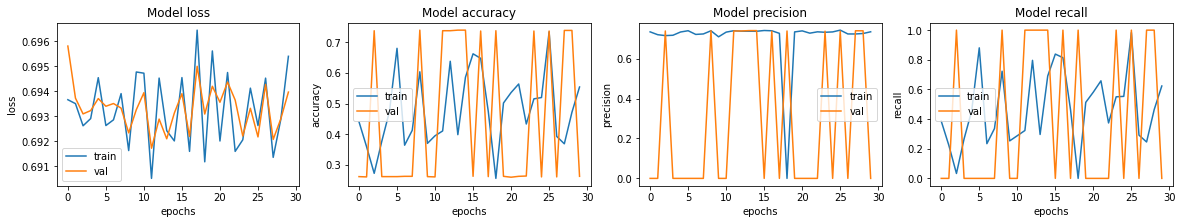

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(metrics_list):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 70ms/step - loss: 0.6936 - accuracy: 0.3750 - precision: 0.0000e+00 - recall: 0.0000e+00
Loss: 0.6935814619064331,
Accuracy: 0.375,
Precision: 0.0,
Recall: 0.0


In [42]:
# 결과 비교를 위한 저장
result_2 = pd.Series([loss, accuracy, precision, recall], index=['loss','accuracy','precision','recall'], name='2nd')

df = pd.concat([result_1, result_2], axis=1)
df

,1st,2nd
loss,1.070583,0.693581
accuracy,0.786859,0.375000
precision,0.746641,0.000000
recall,0.997436,0.000000


> #### feedback
> - 규제가 없으니까 모델의 수렴이 형편없고, 예측도 굉장히 형편없다.
>   - `recall`과 `precision`이 0이면 True Positive(진짜 양성)를 하나도 맞추지 못했다는 것인데, 어떻게 저럴 수 있나 싶다..
> - 그런데 왜 BatchNormalization과 Dropout이 없다고 이렇게 모델이 형편없어질까...?
> - 여튼, 이 정도 depth를 갖고 해당 epoch에 훈련된 모델은 규제가 효율이 있다고 할 수 있을 것 같다.

### 후보 3) BatchNormalization만
- 기존의 모델에서 BatchNormalization만 들어가게 해보자.

In [43]:
def build_model_3rd():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block_regs(32),
        conv_block_regs(64),
        
        conv_block_regs(128),
#        tf.keras.layers.Dropout(0.2),
        
        conv_block_regs(256),
#        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(), # 추가
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(), # 추가
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(), # 추가
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [44]:
# 모델 생성 및 컴파일
with tf.device('/GPU:0'):
    model = build_model_3rd()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [45]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights
    )

Epoch 1/30
261/261 [==============================] - 41s 129ms/step - loss: 0.3102 - accuracy: 0.8634 - precision: 0.9641 - recall: 0.8487 - val_loss: 0.6285 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 33s 127ms/step - loss: 0.1828 - accuracy: 0.9300 - precision: 0.9753 - recall: 0.9276 - val_loss: 1.0125 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 33s 127ms/step - loss: 0.1430 - accuracy: 0.9491 - precision: 0.9816 - recall: 0.9500 - val_loss: 0.5165 - val_accuracy: 0.7962 - val_precision: 1.0000 - val_recall: 0.7243
Epoch 4/30
261/261 [==============================] - 33s 127ms/step - loss: 0.1366 - accuracy: 0.9460 - precision: 0.9871 - recall: 0.9394 - val_loss: 0.2475 - val_accuracy: 0.9163 - val_precision: 0.9069 - val_recall: 0.9883
Epoch 5/30
261/261 [==============================] - 33s 127ms/step - loss: 0.1294 - accura

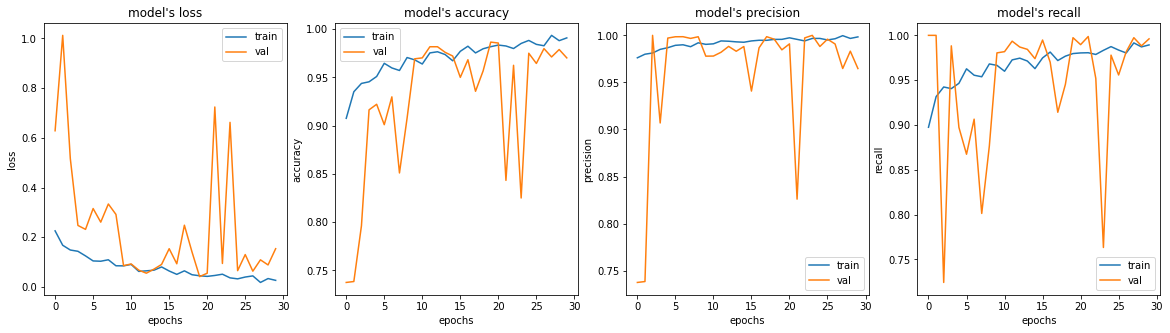

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for idx, met in enumerate(metrics_list):
    ax[idx].plot(history.history[met], label='train')
    ax[idx].plot(history.history['val_' + met], label='val')
    ax[idx].set_title(f"model's {met}")
    ax[idx].set_xlabel('epochs')
    ax[idx].set_ylabel(met)
    ax[idx].legend()

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 72ms/step - loss: 3.3675 - accuracy: 0.7131 - precision: 0.6854 - recall: 1.0000
Loss: 3.367494583129883,
Accuracy: 0.7131410241127014,
Precision: 0.6854130029678345,
Recall: 1.0


In [48]:
# 결과 비교를 위한 저장
result_3 = pd.Series([loss, accuracy, precision, recall], index=['loss','accuracy','precision','recall'], name='3rd')

df = pd.concat([df, result_3], axis=1)
df

,1st,2nd,3rd
loss,1.070583,0.693581,3.367495
accuracy,0.786859,0.375000,0.713141
precision,0.746641,0.000000,0.685413
recall,0.997436,0.000000,1.000000


> #### feedback
> - 그래프 상 train, validation 데이터의 경우 20~25epoch쯤 살짝 튀는 모습을 보여준다..
> - 하지만 test에서 예측 시 비교적 좋지 않은 `loss` 값과 `precision` 값을 보여줬다.
> - test 데이터에는 적합하지 않게 훈련된 모델인 것 같다.

> - 그런데 희한하게 `recall`수치는 굉장히 높다.
> - 이쯤 되니 test 데이터에서 음성/양성의 데이터 비율이 정확도에 많은 영향을 주는 것 같은데, 어느 정도인지 확인해봐야겠다.

In [49]:
# 데이터 imbalance 확인
positive_test = 0
label_list = []
for path in test_tsd:
    strings = tf.strings.split(path, os.path.sep)
    label = strings[-2] == 'PNEUMONIA'
    label_list.append(label)
    if label == True:
        positive_test += 1

print(f'전체 test 데이터 개수 : {len(test_tsd)}')
print(f'양성 test 데이터 개수 : {positive_test}')
print(f'양성 test 데이터 비율 : {positive_test/len(label_list)*100:.2f}')
print('==============================================')
print(f'라벨 처음 5개만 보기 : {label_list[:5]}')

전체 test 데이터 개수 : 624
양성 test 데이터 개수 : 390
양성 test 데이터 비율 : 62.50
라벨 처음 5개만 보기 : [<tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>]


> - train에서는 양성이 약 74%를 차지했고, 이 때문에 weight balancing을 시도했다.
> - 그에 비해 test에서는 양성이 약 62%이다._(비교적 절반에 가까운 것 같다.)_
> - 어쩌면 훈련 시 사용한 weight balancing의 가중치가 음성/양성을 각각 절반에 가깝게 고려할만큼의 수치가 되지 않았나보다.

> - 여튼 Dropout만 적용한 모델의 성능도 확인해야겠다.

### 후보 4) Dropout만 적용
- Dropout은 0.5로 세팅하겠다.

In [50]:
# 기존에 BatchNormalization()이 있던 레이어에 Dropout으로 교체했다.
def build_model_4th():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.5), # <- 변경
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.5), # <- 변경
        tf.keras.layers.MaxPool2D(),

        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.5), # <- 변경
        tf.keras.layers.MaxPool2D(),
       
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5), # <- 변경
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5), # <- 변경
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5), # <- 변경
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [51]:
# 모델 생성 및 컴파일
with tf.device('/GPU:0'):
    model = build_model_4th()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [52]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights
    )

Epoch 1/30
261/261 [==============================] - 40s 129ms/step - loss: 0.6888 - accuracy: 0.6575 - precision: 0.7514 - recall: 0.8129 - val_loss: 0.6919 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 33s 126ms/step - loss: 0.6962 - accuracy: 0.4540 - precision: 0.7549 - recall: 0.3889 - val_loss: 0.7049 - val_accuracy: 0.2615 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
261/261 [==============================] - 33s 126ms/step - loss: 0.6876 - accuracy: 0.3957 - precision: 0.7499 - recall: 0.2949 - val_loss: 0.6886 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 4/30
261/261 [==============================] - 33s 126ms/step - loss: 0.6942 - accuracy: 0.4986 - precision: 0.7207 - recall: 0.5307 - val_loss: 0.6918 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 5/30
261/261 [==============================] - 33s 126ms/step - loss: 0.6973 

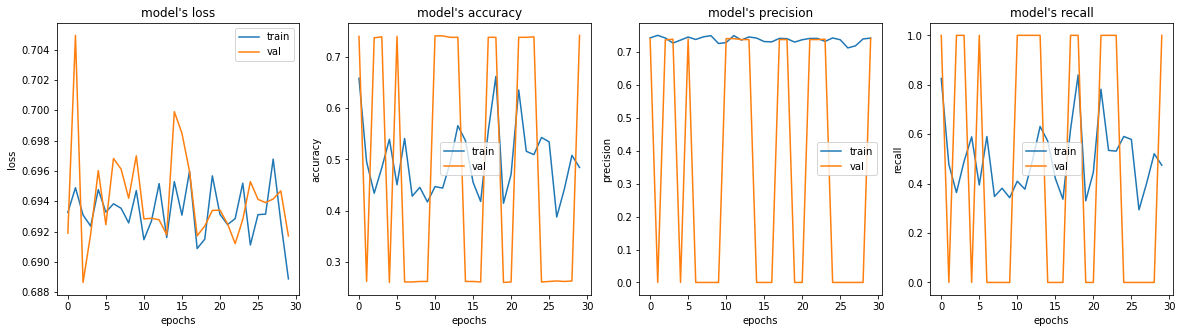

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for idx, met in enumerate(metrics_list):
    ax[idx].plot(history.history[met], label='train')
    ax[idx].plot(history.history['val_' + met], label='val')
    ax[idx].set_title(f"model's {met}")
    ax[idx].set_xlabel('epochs')
    ax[idx].set_ylabel(met)
    ax[idx].legend()

In [54]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 69ms/step - loss: 0.6924 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6924073100090027,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [55]:
# 결과 비교를 위한 저장
result_4 = pd.Series([loss, accuracy, precision, recall], index=['loss','accuracy','precision','recall'], name='4th')

df = pd.concat([df, result_4], axis=1)
df

,1st,2nd,3rd,4th
loss,1.070583,0.693581,3.367495,0.692407
accuracy,0.786859,0.375000,0.713141,0.625000
precision,0.746641,0.000000,0.685413,0.625000
recall,0.997436,0.000000,1.000000,1.000000


> #### feedback
> - 이번 모델은 train, val 데이터 전반에 걸쳐 30epoch 내내 제대로 수렴하지 못하는 모습을 보였다.
> #### 그래서 후보 4개를 합쳤을 때, 결론적으로 규제 부분을 제외하고 17개층을 가진 이번 모델에서는 BatchNormalization과 Dropout을 동시에 한 부분이 더 낫다고 마무리 지으려 한다.

> - 하지만 Dropout이 제대로 실행됐는지가 의문이다.
>   - 예를 들어, Dropout 층의 위치 및 개수가 적절하지 않았을 수 있고,
>   - 또 dropout_rate 역시 적절하지 않았을 수 있다.
>   - 이와 관련해서는 BatchNormalization 역시 제대로 된 이해 없이 진행됐었기에 두 규제 영역에 대해서는 비교를 위해 좀 더 깊은 공부가 필요함을 느낀다.

> #### 그래서 현 시점부터는 예측 지표를 높이기 위해 이것저것 `탐구`해보는 시간을 가지려 한다.

### exploration 1)
- 일단 불균형 데이터에 추가적으로 적용한 각 클래스별 가중치가 적절했는지 의문이다.
- 해당 숫자만 좀 더 바꿔주면 결과가 달라지지 않을까 싶어서 시도해보려 한다.

In [56]:
# 적용할 가중치 계산
# 총합 1이 되도록 했다.
weight_for_neg = COUNT_PNEUMONIA / new_train_num
weight_for_pos = COUNT_NORMAL / new_train_num

balancing_weights_2 = {0:weight_for_neg, 1:weight_for_pos}
print(weight_for_neg)
print(weight_for_pos)
print('===============================================')
print(f'첫번째 가중치 : {balancing_weights}')
print(f'두번째 가중치 : {balancing_weights_2}')

0.7428912783751493
0.25710872162485066
첫번째 가중치 : {0: 1.9447026022304832, 1: 0.6730459954969443}
두번째 가중치 : {0: 0.7428912783751493, 1: 0.25710872162485066}


In [57]:
# 제일 좋다고 판단한 첫번째 모델을 써보겠다.
with tf.device('/GPU:0'):
    model = build_model_1st()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [58]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights_2 # 이 부분 변경
    )

Epoch 1/30
261/261 [==============================] - 41s 131ms/step - loss: 0.2052 - accuracy: 0.7644 - precision: 0.9157 - recall: 0.7477 - val_loss: 0.6904 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 33s 128ms/step - loss: 0.1095 - accuracy: 0.8848 - precision: 0.9588 - recall: 0.8826 - val_loss: 1.3772 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 33s 128ms/step - loss: 0.0773 - accuracy: 0.9176 - precision: 0.9766 - recall: 0.9114 - val_loss: 0.4985 - val_accuracy: 0.7952 - val_precision: 0.7838 - val_recall: 1.0000
Epoch 4/30
261/261 [==============================] - 33s 128ms/step - loss: 0.0804 - accuracy: 0.9190 - precision: 0.9724 - recall: 0.9177 - val_loss: 0.2793 - val_accuracy: 0.8769 - val_precision: 0.8571 - val_recall: 1.0000
Epoch 5/30
261/261 [==============================] - 33s 128ms/step - loss: 0.0690 - accura

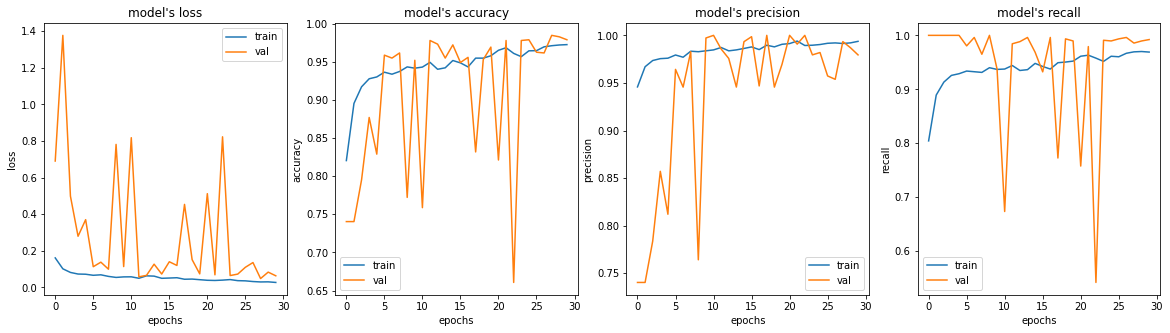

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for idx, met in enumerate(metrics_list):
    ax[idx].plot(history.history[met], label='train')
    ax[idx].plot(history.history['val_' + met], label='val')
    ax[idx].set_title(f"model's {met}")
    ax[idx].set_xlabel('epochs')
    ax[idx].set_ylabel(met)
    ax[idx].legend()

In [60]:
# 예측
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 69ms/step - loss: 1.2390 - accuracy: 0.7276 - precision: 0.6971 - recall: 0.9974
Loss: 1.2389622926712036,
Accuracy: 0.7275640964508057,
Precision: 0.6971325874328613,
Recall: 0.9974358677864075


In [61]:
# 결과 비교를 위한 저장
result_5 = pd.Series([loss, accuracy, precision, recall], index=['loss','accuracy','precision','recall'], name='5th')

df = pd.concat([df, result_5], axis=1)
df

,1st,2nd,3rd,4th,5th
loss,1.070583,0.693581,3.367495,0.692407,1.238962
accuracy,0.786859,0.375000,0.713141,0.625000,0.727564
precision,0.746641,0.000000,0.685413,0.625000,0.697133
recall,0.997436,0.000000,1.000000,1.000000,0.997436


> #### feedback
> - validation 데이터에 대해서는 살짝 불안정적으로 수렴하는 모습이 그려졌다.
> - test 데이터에 대한 예측 loss도 비교적 안 좋은 결과를 보였다.
> - 하지만 역시 `recall`은 높고, `precision`은 낮다.
> - 음성에 대해 양성이라고 판단하는 경우가 많은 것 같다.

> #### weight balancing으로 넣는 가중치가 두 클래스 다 1보다 작은데 그 점도 약간 걸린다. 한 번 1보다 크게 나오도록 해보자.

### exploration 2)
- weight balancing 가중치를 다르게 적용해보자.

In [62]:
# 적용할 가중치 계산
# 음성에 대해서는 1이 넘고, 양성에 대해서는 1보다 작도록 해보겠다.
# 각각의 클래스마다 전체 데이터 개수에 대해 해당 클래스가 가지는 배수(?)를 구하고 그것에 상대방 클래스의 비율을 곱했다.
weight_for_neg = new_train_num / COUNT_NORMAL * COUNT_PNEUMONIA / new_train_num
weight_for_pos = new_train_num / COUNT_PNEUMONIA * COUNT_NORMAL / new_train_num

balancing_weights_3 = {0:weight_for_neg, 1:weight_for_pos}
print(weight_for_neg)
print(weight_for_pos)
print('===============================================')
print(f'첫번째 가중치 : {balancing_weights}')
print(f'두번째 가중치 : {balancing_weights_2}')
print(f'세번째 가중치 : {balancing_weights_3}')

2.8894052044609664
0.3460919909938887
첫번째 가중치 : {0: 1.9447026022304832, 1: 0.6730459954969443}
두번째 가중치 : {0: 0.7428912783751493, 1: 0.25710872162485066}
세번째 가중치 : {0: 2.8894052044609664, 1: 0.3460919909938887}


In [63]:
# 제일 좋다고 판단한 첫번째 모델을 써보겠다.
with tf.device('/GPU:0'):
    model = build_model_1st()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [64]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights_3 # 이 부분 변경
    )

Epoch 1/30
261/261 [==============================] - 41s 130ms/step - loss: 0.4422 - accuracy: 0.7118 - precision: 0.9339 - recall: 0.6597 - val_loss: 0.5885 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 33s 128ms/step - loss: 0.2504 - accuracy: 0.8185 - precision: 0.9841 - recall: 0.7686 - val_loss: 1.3156 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 33s 128ms/step - loss: 0.1900 - accuracy: 0.8622 - precision: 0.9886 - recall: 0.8277 - val_loss: 0.9528 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 4/30
261/261 [==============================] - 33s 127ms/step - loss: 0.1709 - accuracy: 0.8845 - precision: 0.9882 - recall: 0.8556 - val_loss: 0.4247 - val_accuracy: 0.8337 - val_precision: 0.9950 - val_recall: 0.7786
Epoch 5/30
261/261 [==============================] - 33s 128ms/step - loss: 0.1566 - accura

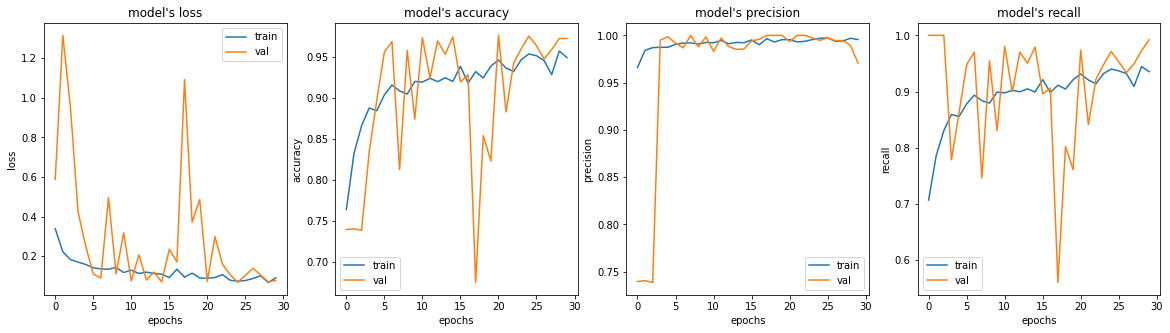

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for idx, met in enumerate(metrics_list):
    ax[idx].plot(history.history[met], label='train')
    ax[idx].plot(history.history['val_' + met], label='val')
    ax[idx].set_title(f"model's {met}")
    ax[idx].set_xlabel('epochs')
    ax[idx].set_ylabel(met)
    ax[idx].legend()

In [66]:
# 예측
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 70ms/step - loss: 1.1832 - accuracy: 0.7260 - precision: 0.6987 - recall: 0.9872
Loss: 1.183248519897461,
Accuracy: 0.7259615659713745,
Precision: 0.6987295746803284,
Recall: 0.9871794581413269


In [67]:
# 결과 비교를 위한 저장
result_6 = pd.Series([loss, accuracy, precision, recall], index=['loss','accuracy','precision','recall'], name='6th')

df = pd.concat([df, result_6], axis=1)
df

,1st,2nd,3rd,4th,5th,6th
loss,1.070583,0.693581,3.367495,0.692407,1.238962,1.183249
accuracy,0.786859,0.375000,0.713141,0.625000,0.727564,0.725962
precision,0.746641,0.000000,0.685413,0.625000,0.697133,0.698730
recall,0.997436,0.000000,1.000000,1.000000,0.997436,0.987179


> #### feedback
> - 이전과 비슷한 결과이다.
> - 이런 방법으로는 개선되지 않을 것 같다.

> - 근데 저런식으로 `recall`과 `precision`값이 나오는 건 확실히 음성데이터에 대한 불균형의 영향이 있는 것 같다...
> - weight balancing에 미련이 남아서 마지막으로 해보겠다.


### exploration 3)
- 가중치의 간격을 더 크게 벌려보자.
- 제곱을 통해 더 격차를 벌려보겠다.

In [68]:
# 적용할 가중치 계산
# 지수화를 통해 더 격차를 벌려보자.
weight_for_neg = (new_train_num / COUNT_NORMAL)**2
weight_for_pos = (new_train_num / COUNT_PNEUMONIA)**2

balancing_weights_4 = {0:weight_for_neg, 1:weight_for_pos}
print(weight_for_neg)
print(weight_for_pos)
print('===============================================')
print(f'첫번째 가중치 : {balancing_weights}')
print(f'두번째 가중치 : {balancing_weights_2}')
print(f'세번째 가중치 : {balancing_weights_3}')
print(f'네번째 가중치 : {balancing_weights_4}')

15.127472844488052
1.8119636482178911
첫번째 가중치 : {0: 1.9447026022304832, 1: 0.6730459954969443}
두번째 가중치 : {0: 0.7428912783751493, 1: 0.25710872162485066}
세번째 가중치 : {0: 2.8894052044609664, 1: 0.3460919909938887}
네번째 가중치 : {0: 15.127472844488052, 1: 1.8119636482178911}


> 이 정도면 거의 gradient exploding이 일어나지 않을까 싶지만... 일단 경험해보자.

In [69]:
# 제일 좋다고 판단한 첫번째 모델을 써보겠다.
with tf.device('/GPU:0'):
    model = build_model_1st()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [70]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights_4 # 이 부분 변경
    )

Epoch 1/30
261/261 [==============================] - 41s 131ms/step - loss: 2.6949 - accuracy: 0.6440 - precision: 0.8988 - recall: 0.5895 - val_loss: 0.5757 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 34s 129ms/step - loss: 1.3075 - accuracy: 0.8252 - precision: 0.9800 - recall: 0.7790 - val_loss: 1.0633 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 33s 128ms/step - loss: 0.9875 - accuracy: 0.8600 - precision: 0.9821 - recall: 0.8275 - val_loss: 0.1217 - val_accuracy: 0.9587 - val_precision: 0.9802 - val_recall: 0.9636
Epoch 4/30
261/261 [==============================] - 33s 128ms/step - loss: 0.8769 - accuracy: 0.8882 - precision: 0.9899 - recall: 0.8586 - val_loss: 0.1282 - val_accuracy: 0.9548 - val_precision: 0.9852 - val_recall: 0.9532
Epoch 5/30
261/261 [==============================] - 33s 128ms/step - loss: 0.8453 - accura

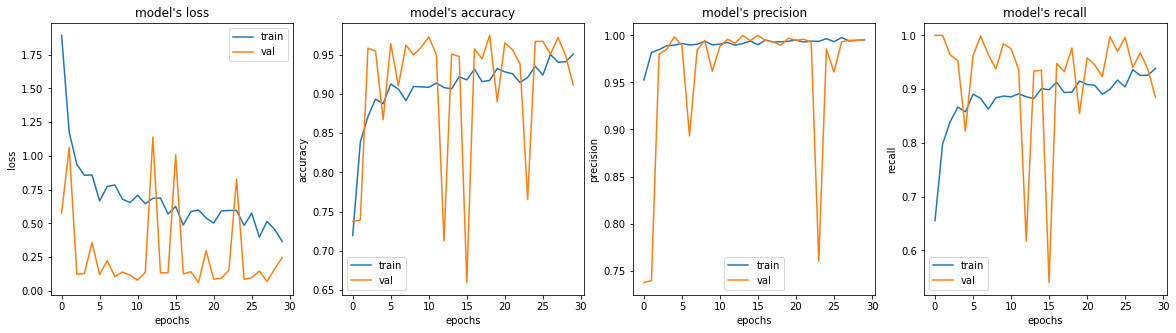

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for idx, met in enumerate(metrics_list):
    ax[idx].plot(history.history[met], label='train')
    ax[idx].plot(history.history['val_' + met], label='val')
    ax[idx].set_title(f"model's {met}")
    ax[idx].set_xlabel('epochs')
    ax[idx].set_ylabel(met)
    ax[idx].legend()

In [72]:
# 예측
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 71ms/step - loss: 0.4099 - accuracy: 0.8862 - precision: 0.9059 - recall: 0.9128
Loss: 0.4099080562591553,
Accuracy: 0.8862179517745972,
Precision: 0.9058524370193481,
Recall: 0.9128205180168152


In [73]:
# 결과 비교를 위한 저장
result_7 = pd.Series([loss, accuracy, precision, recall], index=['loss','accuracy','precision','recall'], name='7th')

df = pd.concat([df, result_7], axis=1)
df

,1st,2nd,3rd,4th,5th,6th,7th
loss,1.070583,0.693581,3.367495,0.692407,1.238962,1.183249,0.409908
accuracy,0.786859,0.375000,0.713141,0.625000,0.727564,0.725962,0.886218
precision,0.746641,0.000000,0.685413,0.625000,0.697133,0.698730,0.905852
recall,0.997436,0.000000,1.000000,1.000000,0.997436,0.987179,0.912821


> #### feedback
> - 그래프를 보면 이전과는 명확하게 다른 양상을 보여준다.
> - train 데이터에 대한 최적화가 기존보다 느리게 진행되는데, 양성 데이터에 대한 가중치 balancing 적용이 꽤 커서 그런 것 같다.
> - 이에 따라 30 epoch 후 training 데이터에 대한 최종 loss값과 accuracy가 지난 모델들에 비해 효율적이지 않다.(loss값은 높다는 뜻)

> - 그런데 test 데이터에 대한 `accuracy`와 `precision은 큰 폭으로 올라갔고, `recall`은 낮아졌다.
> - 그리고 `loss`값도 낮아졌다.
> - 불균형 데이터에 취한 weight balancing 효과가 원했던 수준으로 나타난 것이다.
> - #### 결론적으로 이 정도 가중치가 해당 모델 및 해당 불균형 데이터에 대해 고르게 학습시켜주는 값이 된 것 같다.


------------------------------------------------
------------------------------------------------
------------------------------------------------

### exploration 4) _번외_
- 일단 목표로 한 수치를 이뤘으니 다른 궁금한 것을 해볼 예정이다.
- 계속된 모델 훈련 속에 현재 데이터가 훈련에 적합한지 의구심이 들었었다.
- 이유는,
  - 1) 폐렴 여부가 x-ray 사진에서 뿌옇게 표시되는 이번 데이터는 왠지 더 많은 픽셀을 가진 채로 훈련하는 게 낫지 않나 싶다. 따라서 이미지 크기를 300 * 300으로 해보겠다.
  - 2) validation은 결국 최종적인 test 예측과는 별개인데, 원래 적은 train 데이터를 너무 많이 validation 데이터로 퍼주지 않았나 싶다. 그냥 애초의 train 데이터 갯수로 진행해보겠다.
- #### 그래서 위와 같은 형태의 데이터를 갖고 마지막에 설계된 모델에 훈련 후 다시 한 번 test 데이터 예측을 해보겠다.

In [74]:
# 이미지 사이즈 재설정
IMAGE_SIZE = (300, 300)

In [75]:
# 파일 경로들 리스트로 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))
print('==============================================')

# 파일 경로들 TensorSliceDataset으로 만들어주기
train_tsd = tf.data.Dataset.from_tensor_slices(train_filenames)
test_tsd = tf.data.Dataset.from_tensor_slices(test_filenames)
val_tsd = tf.data.Dataset.from_tensor_slices(val_filenames)

# 전체 데이터 개수 사용의 효율성을 위한 변수 할당
TRAIN_IMG_COUNT = len(train_tsd)
VAL_IMG_COUNT = len(val_tsd)

print('객체 종류 및 개수 확인')
print('==============================================')
print(type(train_tsd), len(train_tsd))
print(type(test_tsd), len(test_tsd))
print(type(val_tsd), len(val_tsd))

# 이미지 데이터 불러오기
train_ds = train_tsd.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_tsd.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_tsd.map(process_path, num_parallel_calls=AUTOTUNE)

# test_ds는 또 다른 전처리가 필요없고, 추후 batch로 들어갈 것이니 batch화 해준다
test_ds = test_ds.batch(BATCH_SIZE)

# 잘 만들어졌는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

5216
624
16
객체 종류 및 개수 확인
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 5216
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 624
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> 16
Image shape:  (300, 300, 3)
Label:  False


In [76]:
# train, val 전처리
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 imbalance 확인
positive_count = 0
label_group = []
for path in train_tsd:
    strings = tf.strings.split(path, os.path.sep)
    label = strings[-2] == 'PNEUMONIA'
    label_group.append(label)
    if label == True:
        positive_count += 1

print(f'전체 훈련 데이터 개수 : {len(train_tsd)}')
print(f'양성 훈련 데이터 개수 : {positive_count}')
print(f'양성 훈련 데이터 비율 : {positive_count/len(label_group)*100:.2f}')
print('==============================================')
print(f'라벨 처음 5개만 보기 : {label_group[:5]}')

전체 훈련 데이터 개수 : 5216
양성 훈련 데이터 개수 : 3875
양성 훈련 데이터 비율 : 74.29
라벨 처음 5개만 보기 : [<tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>, <tf.Tensor: shape=(), dtype=bool, numpy=False>]


#### 모델 훈련 및 평가

In [77]:
# 위와 동일하게 모델 설계
with tf.device('/GPU:0'):
    model = build_model_1st()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [78]:
with tf.device('/GPU:0'):
    
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=balancing_weights_4 # data imbalance가 비슷하니 이 부분도 동일하게 하는 게 유의미한 것 같다.
    )

Epoch 1/30
326/326 [==============================] - 132s 244ms/step - loss: 6.5340 - accuracy: 0.5519 - precision: 0.5194 - recall: 0.3891 - val_loss: 0.6947 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
326/326 [==============================] - 79s 243ms/step - loss: 5.7649 - accuracy: 0.5508 - precision: 0.5339 - recall: 0.3226 - val_loss: 0.6909 - val_accuracy: 0.5625 - val_precision: 1.0000 - val_recall: 0.1250
Epoch 3/30
326/326 [==============================] - 79s 242ms/step - loss: 5.1242 - accuracy: 0.5410 - precision: 0.5093 - recall: 0.2283 - val_loss: 0.6374 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1250
Epoch 4/30
326/326 [==============================] - 79s 243ms/step - loss: 4.4507 - accuracy: 0.5924 - precision: 0.5796 - recall: 0.2866 - val_loss: 0.6484 - val_accuracy: 0.6250 - val_precision: 0.7500 - val_recall: 0.3750
Epoch 5/30
326/326 [==============================] - 79s 243ms/step - loss: 4.5544

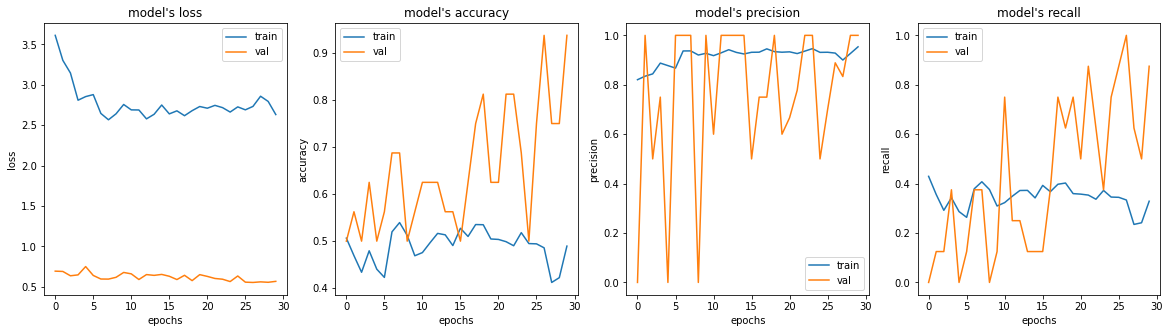

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for idx, met in enumerate(metrics_list):
    ax[idx].plot(history.history[met], label='train')
    ax[idx].plot(history.history['val_' + met], label='val')
    ax[idx].set_title(f"model's {met}")
    ax[idx].set_xlabel('epochs')
    ax[idx].set_ylabel(met)
    ax[idx].legend()

In [80]:
# 예측
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 78ms/step - loss: 0.6013 - accuracy: 0.7436 - precision: 0.8808 - recall: 0.6821
Loss: 0.6013361811637878,
Accuracy: 0.7435897588729858,
Precision: 0.8807947039604187,
Recall: 0.6820513010025024


In [81]:
# 결과 비교를 위한 저장
result_8 = pd.Series([loss, accuracy, precision, recall], index=['loss','accuracy','precision','recall'], name='8th')

df = pd.concat([df, result_8], axis=1)
df

,1st,2nd,3rd,4th,5th,6th,7th,8th
loss,1.070583,0.693581,3.367495,0.692407,1.238962,1.183249,0.409908,0.601336
accuracy,0.786859,0.375000,0.713141,0.625000,0.727564,0.725962,0.886218,0.743590
precision,0.746641,0.000000,0.685413,0.625000,0.697133,0.698730,0.905852,0.880795
recall,0.997436,0.000000,1.000000,1.000000,0.997436,0.987179,0.912821,0.682051


In [82]:
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 300, 300, 16)      2320      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
sequential_46 (Sequential)   (None, 75, 75, 32)        2160      
_________________________________________________________________
sequential_47 (Sequential)   (None, 37, 37, 64)        7392      
_________________________________________________________________
sequential_48 (Sequential)   (None, 18, 18, 128)       27072     
_________________________________________________________________
dropout_26 (Dropout)         (None, 18, 18, 128)     

> #### feedback
> - 무슨 탓인지 일단 `recall`이 굉장히 낮아졌다.
> - 그리고 `precision`은 괜찮은 수치가 나왔다.
> - 즉, 음성에 대한 학습은 잘되었고, 양성에 대한 학습은 비교적 덜 된 것 같다.

> - 이와 관련해서는
> - 실험 변수로 택한 `데이터 개수 증가` 혹은 `이미지 크기 증가`가 현재 weight balancing 가중치와 잘 안 맞는다는 것 같은데, 아무래도 데이터 증가는 미미한 수준이니 `input 이미지 크기 증가`가 영향을 끼친 것 같다.
> - 그리고 `이미지 크기 증가`는 어떻게 영향을 주었을까 생각해보니 그로 인한 `학습 파라미터 수 증가`가 모델 학습에 영향을 준 것 같다.
> - 위를 통해 확인하니 `180x180` -> `300x300`의 사이즈 변경은 파라미터에서 약 340만 -> 약 1000만으로 증가한 것을 볼 수 있었다.
> - #### 이로써 위의 추측, 즉 `학습 파라미터 수 증가`가 불균형 데이터에 취한 나의 weight balancing과 적절하게 섞이지 않았다는 것이 맞는 것 같다.
> - #### 파라미터 수의 증가에 따라 모델 훈련 시간이 길어져서 `이미지 크기 증가`를 통해 모델 학습을 개선시켜보려 한 번외 실험은 여기서 마무리 지으려 한다.

# 회고
#### Point 1) x-ray 이미지의 크기
- 폐렴 x-ray 이미지의 경우 선명한 물체의 존재 여부로 판단하는 게 아니라 대부분 연기 퍼지듯 산개한 하얀색 부분을 통해 진단하는 만큼 input 이미지가 더 많은 픽셀값을 갖는 게 유리하지 않을까 아직도 생각하고 있다.

#### Point 2) 의료 데이터의 augmentation
- 사실 의료 분야가 인공지능을 통해 가장 빠르게 혁신되지 않을까 기대했었는데, 데이터 관련 어려움이 있는지 몰랐다.
- 그리고 워낙 정성적이고 복합적인 부분들이 연계된 채 판단을 해야하는 분야여서 기대했던 것 만큼 빠르게 의사들의 자리를 꿰차지(?)는 못하지 않을까 싶다.
- 찾아보던 중 폐렴 x-ray 데이터의 경우 GAN을 통한 데이터 생성이 비교적 많이 연구된 것 같은데, 그러한 부분도 참 흥미로워 보인다.(공부할 것만 늘어나는 느낌이다...)

#### Point 3) 실험 실행의 제약
- 이번 데이터를 갖고 여러가지 시도해보고 싶은 게 많았다.
- 왜냐하면 하나하나 해보면서 어떤 역할을 하는지 알아보고 싶었기 때문이다.
- 예를 들어, 내가 직접 이것저것 모델도 설계해보고 싶었고, 이전에 해본 transfer learning도 해보고 싶었고, data augmentation 관련해서 더 획기적인 방법은 없는지 많은 실험을 해보고 싶었는데,
- 결과적으로 '물리적인 시간'이 부족했다.
- 해보고 싶은 게 1개씩 생길수록 decision tree가 가지를 뻗쳐가는 모양 같이 내가 고려할 것은 기하급수적으로 늘어나는데, 사실 그 모든 것을 할 형편은 안된다.
- 나는 이러한 점이 나중에 이런 분야에서 일을 할 때 실제적인 어려움으로 다가오지 않을까 싶다.
- 즉, 알아내고, 시도해봐야 할 것은 많지만 컴퓨터 하드웨어 여건상, 혹은 내 물리적인 시간의 여건상 그 많은 것을 필요한 시간 내에 시도해보지 못하는 것이다.
- 뭐 지금에서야 쓸 데 없는 걱정이겠지만, 실제 인공지능 개발자로서의 삶을 상상해보는 계기가 되었다.

#### Point 4) BatchNormalization의 목적
- 이번 노드에서 BatchNormalization은 규제로서 소개되었다.
- 그런데 BatchNormalization에 이해하려고 찾아보던 중 Andrew Ng은 BN의 목적을 `규제`로 두지 말라고 얘기한다.(https://www.youtube.com/watch?v=nUUqwaxLnWs)
- BN의 가장 적합한 목적은 은닉층의 입력값을 정규화함으로서 batch마다 분산이 크게 달라지는 것을 방지하고, 이를 통해 `학습을 빠르게 할 수 있게` 해주는 것이란다.
- 공부를 할 때마다 느끼는 건 머신러닝은 정말 수학이고, 그 수학을 이해해야 직관적인 의미를 파악할 수 있다는 것이다.
- 수학을 통해 머신러닝에 접근하는 근육을 길러야겠다.

#### Point 5) `recall`이 0이 나온 이유
- 위에 후보 2)의 예측값을 보면 `recall`이 0이 나온다.(사실 해당 주피터노트북을 여러번 돌렸을 때마다 값이 다르긴 했다.)
- 그리고 `precision`도 0이어서, 정리하면 True Positive는 하나도 못 맞춘 셈인 것이다.
- 좀 더 지표적으로 보니 `accuracy`는 0.375인데, 0.375는 test 데이터에서 음성 데이터 갯수의 비율과 동일하다.
- 즉 이 모델은 그냥 모든 것을 음성으로 판단했다는 것이다.
- 왜 이렇게 된 걸까?
- 참고로 해당 모델은 BN도 안 쓰고 Dropout도 없는 것인데, 단순히 그 이유만으로 모델이 이렇게 형편없게 학습될 수 있을까...?
- 솔직히 이런 부분은 먼저 겪어봤던 퍼실 분들이나 더 고수 분들의 해석을 들어보고 싶다.
